In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
from distgen import Generator
from distgen.physical_constants import unit_registry
from astra.astra_distgen import evaluate_astra_with_distgen
from pmd_beamphysics.plot import marginal_plot
import pickle
import sys
import os

font = {'size'   : 20}

mpl.rc('font', **font)



sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/devices/profile_monitor')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/devices/magnet')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/image_processing')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/cor_plot')
from lcls_tools import image_processing as imp
from cor_plot_mat_scan import CorPlotMatScan as C


from lcls_tools import image_processing as imp
import ImageProcessing as mip

In [3]:
!pwd

/global/u1/l/lgupta/cori/GitHub/lcls-sc-inj-surrogate/paper


In [4]:
def returnImportantStuff(input_file, bins = 100, nparticles = 1000):
    gen = Generator(input_file)
    gen.input['n_particle'] = nparticles
    #gen.input['r_dist:sigma_xy:value'] = 1/5
    gen.run()
    particles = gen.particles
    px = particles['x']
    py = particles['y']
    sig_x = particles['sigma_x']
    sig_y = particles['sigma_y']
    xhist = np.histogram(px, bins = bins)
    yhist = np.histogram(py, bins = bins)
    H, xedges, yedges = np.histogram2d(px, py, bins=bins)
    return particles, xhist, yhist, H

SG_IN = "files/2019_11_01_005754.yaml"
VCC_IN = "files/2019-11-01T00:57:54_laser_in.yaml"
ASTRA_IN = "/global/homes/l/lgupta/cori/GitHub/lcls-lattice/astra/models/gunb_eic/astra.in"
ARCHIVE_PATH = "/global/u1/l/lgupta/m669/datasets/temp"

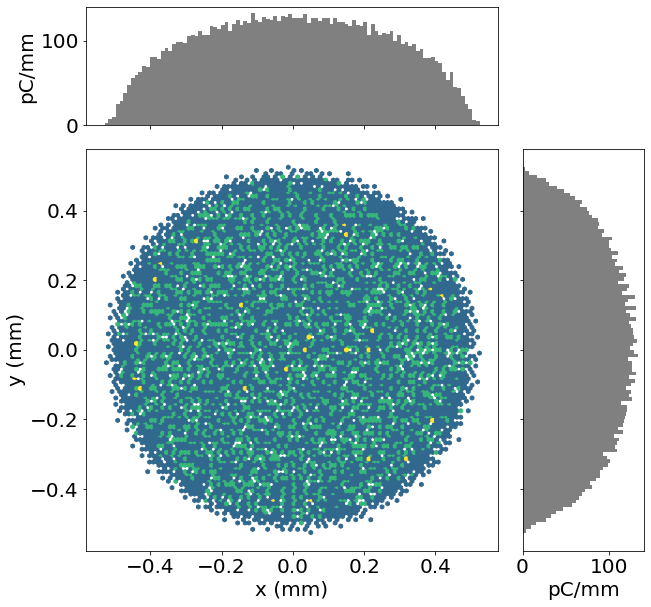

In [5]:
particles, hx, hy, H= returnImportantStuff(SG_IN, bins = 100, nparticles = 10000)
mpl.rcParams['figure.figsize'] = (10,10)
marginal_plot(particles, 'x', 'y', bins = 100)

In [6]:
file = 'files/CorrelationPlot-SOLN_GUNB_212_BCTRL-2019-11-01-003233.mat'

def getCorrInfo(file):
    data = C(file)
    s = data.samples
    x = data.ctrl_vals
    yarray = []
    yerr = []

    for i in range(0, len(x)):
        yvals = []
        for j in range(0, s):
            yvals.append(((data.beam[i][j][0]['xStat'])[0])[2])
        meany = np.mean(np.array(yvals))
        yarray.append(meany)

        stdy = np.std(yvals)
        yerr.append(stdy)
    yarray = np.array(yarray)
    x = np.array(x)
    return x, yarray, yerr

x, y, ye = getCorrInfo(file)

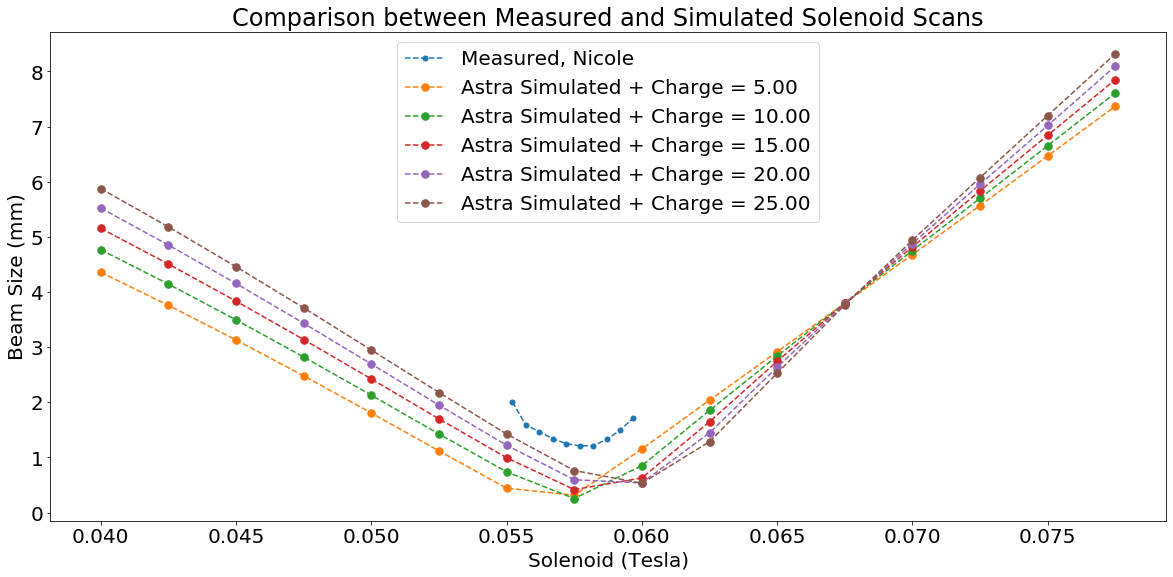

In [26]:
settings ={"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 20.0 , "zphase": 20}


ALL = {}
plt.figure(figsize = (20,9))
plt.plot(x/(0.1342*(1/10**(-4))*10**-3), y*1E-3, '.--', markersize = 10, label = "Measured, Nicole")
charges = [5, 10, 15, 20, 25]
for c in charges:

    all_outputs = {}
    beam_sizes = []
    solenoids = []
    count = 0

    
    for i in np.arange(0.04, 0.08, 0.0025):
        settings["maxb(2)"] = i
        settings["distgen:total_charge:value"] = c
        A = evaluate_astra_with_distgen(settings, astra_input_file=ASTRA_IN,
                        distgen_input_file=SG_IN, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[count] = A
        beam_sizes.append(A["end_sigma_x"])
        solenoids.append(i)
        count = count + 1
        
    
    ALL[c] = all_outputs
    
    plt.plot(solenoids, np.array(beam_sizes)*1E3, '.--', markersize = 15, label = "Astra Simulated + Charge = {:.2f}".format(c))

    plt.title("Comparison between Measured and Simulated Solenoid Scans")
    plt.xlabel("Solenoid (Tesla)")
    plt.ylabel("Beam Size (mm)")
    

    
    
    
plt.legend()
plt.show()

# with open('solenoid_scan.pickle', 'wb') as handle:
#     pickle.dump(all_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print("Done")

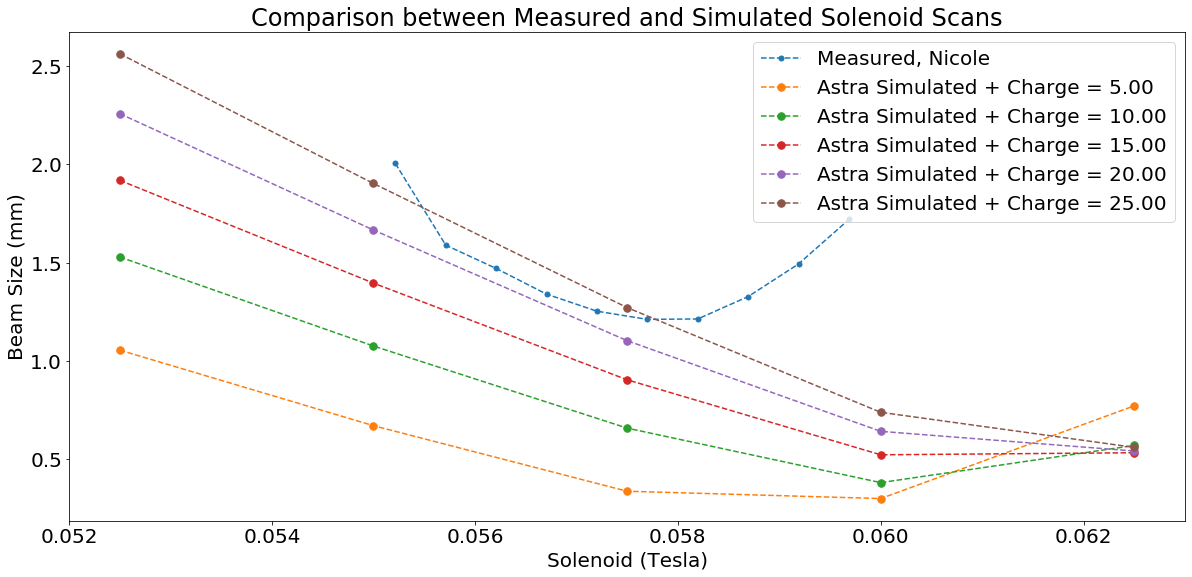

In [33]:
settings ={"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 20.0 , "zphase": 20, "distgen:r_dist:sigma_xy:value": 0.25}


ALL = {}
plt.figure(figsize = (20,9))
plt.plot(x/(0.1342*(1/10**(-4))*10**-3), y*1E-3, '.--', markersize = 10, label = "Measured, Nicole")
charges = [5, 10, 15, 20, 25]
for c in charges:

    all_outputs = {}
    beam_sizes = []
    solenoids = []
    count = 0

    
    for i in np.arange(0.0525, 0.0625, 0.0025):
        settings["maxb(2)"] = i
        settings["distgen:total_charge:value"] = c
        A = evaluate_astra_with_distgen(settings, astra_input_file=ASTRA_IN,
                        distgen_input_file=SG_IN, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[count] = A
        beam_sizes.append(A["end_sigma_x"])
        solenoids.append(i)
        count = count + 1
        
    
    ALL[c] = all_outputs
    
    plt.plot(solenoids, np.array(beam_sizes)*1E3, '.--', markersize = 15, label = "Astra Simulated + Charge = {:.2f}".format(c))

    plt.title("Comparison between Measured and Simulated Solenoid Scans")
    plt.xlabel("Solenoid (Tesla)")
    plt.ylabel("Beam Size (mm)")
    

    
    
    
plt.legend()
plt.show()

# with open('solenoid_scan.pickle', 'wb') as handle:
#     pickle.dump(all_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print("Done")

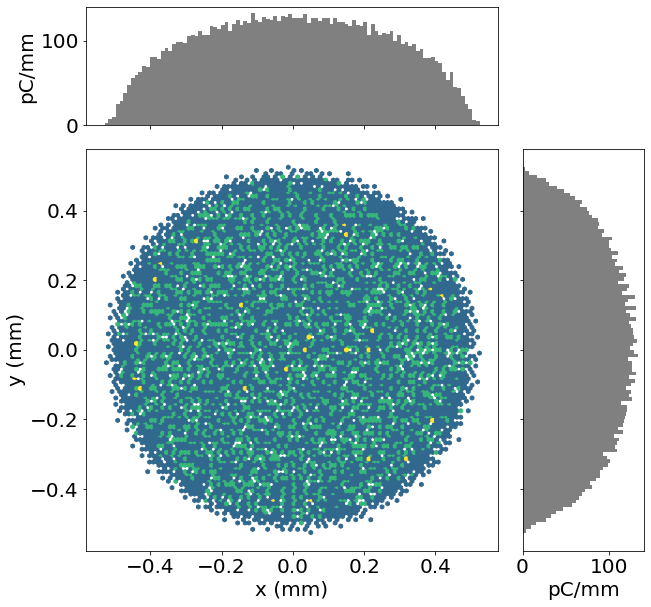

In [34]:
particles, hx, hy, H= returnImportantStuff(SG_IN, bins = 100, nparticles = 10000)
mpl.rcParams['figure.figsize'] = (10,10)
marginal_plot(particles, 'x', 'y', bins = 100)

In [ ]:

charges = [5, 10, 15, 20, 25]

Text(0, 0.5, 'Sigma_x, (mm)')

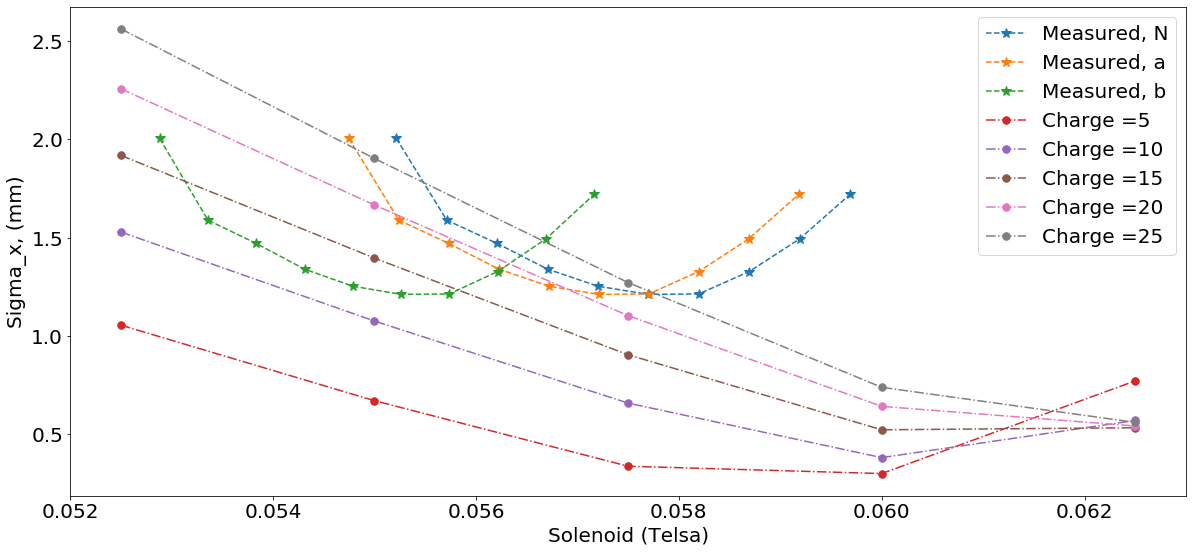

In [63]:
plt.figure(figsize = (20,9))
plt.plot(x/(0.1342*(1/10**(-4))*10**-3), y*1E-3, '*--', markersize = 10, label = "Measured, N")
plt.plot(x*0.7388398262208369, y*1E-3, '*--', markersize = 10, label = "Measured, a")
plt.plot(x*0.713674982003506, y*1E-3, '*--', markersize = 10, label = "Measured, b")
for k, v in ALL.items():
    bs = []
    for i, j in v.items():
        bs.append(v[i]["end_sigma_x"]*1E3)
    plt.plot(solenoids, bs, '.-.', markersize = 15, label = "Charge =" + str(k))
    
plt.legend()
plt.xlabel("Solenoid (Telsa)")
plt.ylabel("Sigma_x, (mm)")

In [ ]:
# REDO with: 
#     -- sg that is 1mm (looked up from the motor angle look up)
#     -- a few charges around 20pC to see how this focal point changes (pretty sensitive to charge)